## Section 4.1

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from scipy import stats
import os

cwd = os.getcwd()
if cwd[-11:] != "Lab_2_again":
    os.chdir("/Users/efrainmartinez/Downloads/SBU/SBU_Spring_2024_Semester/AST443/Labs/AST_443/Lab_2_again")


In [ ]:
dark_30s_prefix = "dark_30sec_.00000"
dark_30s_end = ".DARK.FIT"
dark_30s_data = []
for i in range(285, 295, 1):
        filename = dark_30s_prefix + str(i) + dark_30s_end
        list = fits.open('dark_frames/'+filename)
        image_data = list[0].data
        dark_30s_data.append(image_data)
        
flat_ad_prefix = "flat_field_ad_.0000000"
flat_ad_end = ".FIT"
flat_ad_data = []
for i in range(0, 10):
    filename = flat_ad_prefix + str(i) + flat_ad_end
    list = fits.open('flat_fields/'+filename)
    image_data = list[0].data
    flat_ad_data.append(image_data)

In [ ]:
median_dark_30s = np.median(dark_30s_data, axis=0)

median_flat_ad = np.median(flat_ad_data, axis=0)
median = np.median(median_flat_ad)
norm_flat_ad = median_flat_ad / median

# flatten_norm_flat_ad = norm_flat_ad.flatten()
# mean = np.mean(flatten_norm_flat_ad)
# std = stats.tstd(flatten_norm_flat_ad)
# plt.imshow(norm_flat_ad, cmap='gray', vmin = mean-3*std, vmax=mean+3*std)
# plt.colorbar()

In [ ]:
image_30s_prefix = "exposure_30sec.00000"
image_30s_end = ".FIT"
image_30s_data = []
for i in range(0, 284):
    if i < 10:
        filename = image_30s_prefix + "00" + str(i) + image_30s_end
        list = fits.open('images/'+filename)
        image_data = list[0].data
        image_30s_data.append(image_data)
    elif i<100:
        filename = image_30s_prefix + "0" + str(i) + image_30s_end
        list = fits.open('images/'+filename)
        image_data = list[0].data
        image_30s_data.append(image_data)
    else:
        filename = image_30s_prefix + str(i) + image_30s_end
        list = fits.open('images/'+filename)
        image_data = list[0].data
        image_30s_data.append(image_data)
        
with fits.open('images/exposure_30sec.00000000.FIT') as hdul:
               print(repr(hdul[0].header))

In [ ]:
final_30s_data = []

for i in range(0, len(image_30s_data)):
    final_30s_data.append((image_30s_data[i]-median_dark_30s) / norm_flat_ad)

flattened = final_30s_data[0].flatten()
mean_final = np.mean(flattened)
std_final = stats.tstd(flattened)
plt.imshow(final_30s_data[0], cmap = 'gray', vmin = mean_final-3*std_final, vmax=mean_final+3*std_final)
plt.colorbar()

In [ ]:
final_30s_data = []

for i in range(0, len(image_30s_data)):
    final_30s_data.append((image_30s_data[i]-median_dark_30s) / norm_flat_ad)

flattened = final_30s_data[0].flatten()
mean_final = np.mean(flattened)
std_final = stats.tstd(flattened)
plt.imshow(final_30s_data[0], cmap = 'gray', vmin = mean_final-3*std_final, vmax=mean_final+3*std_final)
plt.colorbar()

In [ ]:
with fits.open('calib_30s.000.FIT') as hdul:
    data = hdul[0].data
    print(repr(hdul[0].header))
flat_data = data.flatten()
mean_data = np.mean(flat_data)
std_data = stats.tstd(flat_data)

plt.imshow(data, cmap='gray', vmin = mean_data - 3*std_data, vmax = mean_data + 3*std_data)
plt.colorbar()

## 4.2

The following bash script iterates over all of our science data, solving for WCS using **astrometry.net** and using XO-2N's RA/Dec as an initial guess. The same was done using Kepler-1's RA/Dec.

In [ ]:
#! /bin/bash -u                                                                 

for file in $(ls -1 *.FIT)
do
   solve-field --ra 117.082 --dec 50.298 --radius 2 ${file}
done

## 4.3

We choose an aperature diameter of 18.882172 pixels. This decision was made by using **ds9**'s region functions and determining an area that encapsulates all of Kepler-1. 

Firstly, the input files are sorted numerically so that they are input sequentially in the output data file. Then, we take the specific catalogue file number (e.g. '020' from calib_30s.020s.cat) and retrieve the date of observation from the corresponding fits file. The relevant data (i.e. flux and flux error) is read in from the catalogue file using a RA and Dec mask corresponding to the coordinates of the object of interest. If the object is not found in an image, a placeholder value of 0.001 is given for the flux and flux error for that file. The JD of observation, flux, and flux error are output into a data file. The process then repeats as the program loops through every catalogue file.

In [ ]:
import os
import numpy as np
from astropy.io import fits
from astropy.time import Time

# Get a list of all files in the directory
file_list = os.listdir('new_source_extractor')

# Filter and sort files numerically based on the number part before the extension
file_list = [file_name for file_name in file_list if file_name.startswith('calib_30s') and file_name.endswith('.cat')]
file_list.sort(key=lambda x: int(x.split('.')[-3].split('_')[-1]))
ts = []
# Open the data file for writing
with open('kepler1.dat', 'w') as f:
    # Iterate over each file in the directory
    for file_name in file_list:
        # Extract file number
        file_number = file_name.split('.')[-3].split('_')[-1]

        # Extract time of observation from FITS header
        fits_file_path = os.path.join('../images', 'exposure_30sec.00000' + file_number + '.FIT')
        with fits.open(fits_file_path) as hdul:
            header = hdul[0].header
            time_of_observation = header['DATE-OBS']

        t = Time(time_of_observation, format='fits', scale='utc')
        t_plot = t.jd
        
        # Load data from file
        data = np.loadtxt(os.path.join('new_source_extractor', file_name))

        # Extract columns from the data
        index = data[:,0]
        right_ascensions = data[:, 3]
        decs = data[:, 4]
        flux = data[:, 5]
        flux_err = data[:, 6]

        # Define masks for right ascensions and declinations
        ra_mask = (right_ascensions < 286.81) & (right_ascensions > 286.795)
        dec_mask = (decs < 49.33) & (decs > 49.31)

        # Combine masks using logical AND
        combined_mask = ra_mask & dec_mask

        # Apply the combined mask to get the indices where the condition is True
        indices = np.where(combined_mask)

        # Extract the values based on the combined mask
        xo_flux = flux[indices[0]]
        xo_flux_err = flux_err[indices[0]]

        if len(xo_flux) == 0:
            xo_flux = np.array([0.001])
            xo_flux_err = np.array([0.001])


        #print(file_name, index[indices], xo_flux, xo_flux_err)

        # Stack flux and flux error into columns
        
        stacked_data = np.column_stack((t_plot,xo_flux, xo_flux_err))

        # Write the file name, time of observation, and the stacked data to the data file

        np.savetxt(f, stacked_data)


Text(0.5, 1.0, 'Kepler-1: $\\alpha$ = 286.8, $\\delta$ = 49.32')

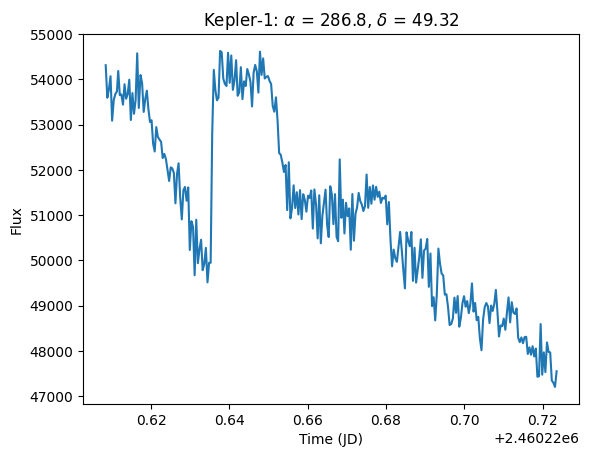

In [2]:
import matplotlib.pyplot as plt
import numpy as np
#286.8 49.32

alpha = 286.8
dec = 49.32

data = np.loadtxt('NEW_SECTION_4_3/kepler1.dat')

time = data[:,0]
flux = data[:,1]
plt.xlabel('Time (JD)')
plt.ylabel('Flux')
plt.plot(time,flux[:])
plt.title(rf'Kepler-1: $\alpha$ = {alpha}, $\delta$ = {dec}')

## Section 4.4

In this first box what I'm doing is just importing the data for each of the refence stars and saving the JD, flux, and flux errors in the respective arrays. For each reference star the index corresponding to it in the array is just REF#-1 then, since the indices for the arrays start at 0.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits

JDs = []
flux = []
flux_err = []

with open("NEW_SECTION_4_3/kepler1.dat") as file:
    lines = file.readlines()
    column0 = []
    column1 = []
    column2 = []
    for x in lines:
        column0.append(float(x.split(' ')[0]))
        column1.append(float(x.split(' ')[1]))
        column2.append(float(x.split(' ')[2]))
    JDs.append(column0)
    flux.append(column1)
    flux_err.append(column2)

for i in range(1, 11):
    filename = "NEW_SECTION_4_3/ref" + str(i) + ".dat"
    with open(filename, 'r') as file:
        lines = file.readlines()
        column0 = []
        column1 = []
        column2 = []
        for x in lines:
            column0.append(float(x.split(' ')[0]))
            column1.append(float(x.split(' ')[1]))
            column2.append(float(x.split(' ')[2]))
        JDs.append(column0)
        flux.append(column1)
        flux_err.append(column2)
        
print(repr(fits.open('images/exposure_30sec.00000283.FIT')[0].header))

In [ ]:
#This is just to stack the plots together
step = 0.3
for i in [0, 5]:
    scaled_flux_no_0[i+1] += step
    scaled_flux_no_0[i+2] += 2*step
    scaled_flux_no_0[i+3] += 3*step
    scaled_flux_no_0[i+4] += 4*step
    scaled_flux_no_0[i+5] += 5*step
    
for j in [0, 5]:
    plt.figure(figsize=(10, 6))
    for i in range(1, 6):
        i += j
        time = (np.asarray(JDs_no_0[i]) - JDs_no_0[i][0])
        centered_time = np.asarray(time - 0.05231309686350435) * 24
        plt.xlabel('Time from Mid-Transit (hours)')
        plt.plot(centered_time, scaled_flux_no_0[i][:len(time)], label=rf"REF {i}")
        plt.ylabel('Scaled Flux')
        plt.title(rf'Reference Star Light Curves')
    time = (np.asarray(JDs_no_0[0]) - JDs_no_0[0][0])
    centered_time = np.asarray(time - 0.05231309686350435) * 24
    plt.plot(centered_time,scaled_flux_no_0[0], label="TrES-2b")
    plt.legend(loc='upper right', framealpha=1)
    plt.show()

## Section 4.5

In this section our goal is to take the calibrated data of TrES-2b and the reference stars and begin to reduced them further to get our finalized lightcurve of the transit

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits

JDs = []
flux = []
flux_err = []

with open("NEW_SECTION_4_3/kepler1.dat") as file:
    lines = file.readlines()
    column0 = []
    column1 = []
    column2 = []
    for x in lines:
        column0.append(float(x.split(' ')[0]))
        column1.append(float(x.split(' ')[1]))
        column2.append(float(x.split(' ')[2]))
    JDs.append(column0)
    flux.append(column1)
    flux_err.append(column2)

for i in range(1, 11):
    filename = "NEW_SECTION_4_3/ref" + str(i) + ".dat"
    with open(filename, 'r') as file:
        lines = file.readlines()
        column0 = []
        column1 = []
        column2 = []
        for x in lines:
            column0.append(float(x.split(' ')[0]))
            column1.append(float(x.split(' ')[1]))
            column2.append(float(x.split(' ')[2]))
        JDs.append(column0)
        flux.append(column1)
        flux_err.append(column2)
        
# The list corresponding to our last reference star does not have the last time on the measuremnet
# Rather than try to come up with some data on that last part, I cut out the last point on the other lists
for i in range(0, 10):
    JDs[i].pop(-1)
    flux[i].pop(-1)
    flux_err[i].pop(-1)



In [ ]:
index = 0
while index < 11:
    j = 0
    for j in range(0, len(flux[index][:])):
        if j >= len(flux[index][:]):
            break
        if flux[index][j] == 0.001 or flux[index][j] < 0.:
            JDs[index].pop(j)
            flux[index].pop(j)
            flux_err[index].pop(j)
            j -= 1
    if 0.001 in flux[index]:
        index -= 1
    index += 1

#2460347.489977

In [ ]:
index = 0
while index < 11:
    j = 0
    for j in range(0, len(flux[index][:])):
        if j >= len(flux[index][:]):
            break
        if flux[index][j] == 0.001 or flux[index][j] < 0.:
            JDs[index].pop(j)
            flux[index].pop(j)
            flux_err[index].pop(j)
            j -= 1
    if 0.001 in flux[index]:
        index -= 1
    index += 1


In [ ]:
for i in range(0, 11):
    times = (np.asarray(JDs[i]) - JDs[0][0]) * 24 - 1.25551
    plt.figure(figsize=(10, 6))
    plt.xlabel('Time from Mid-Transit (hours)')
    plt.errorbar(times, flux[i], yerr=flux_err[i], linestyle='', color='r', alpha=0.7)
    plt.plot(times,flux[i])
    plt.ylabel('Flux (counts)')
    if i == 0:
        plt.title("Kepler 1")
    else:
        plt.title(rf'REF {i}')
    plt.show()

In [ ]:
# Here we want to line up our data so that when we calculate the weighted means we're not
# mixing our points together

ind_targ = ind_1 = ind_2 = ind_2 = ind_3 = ind_4 = ind_5 = ind_6 = ind_7 = ind_8 = ind_9 = ind_10 = 0
ind = [ind_targ, ind_1, ind_2, ind_3, ind_4, ind_5, ind_6, ind_7, ind_8, ind_9, ind_10]

weighted_means = []
weighted_errs = []

while np.max(ind) < len(JDs[0]):
    temp_flux = []
    temp_flux_err = []
    temp_flux = np.array(temp_flux)
    temp_flux_err = np.array(temp_flux_err)
    date = JDs[0][ind[0]]

    for i in range(1, 11):
        if ind[i] >= len(JDs[i]):
            break
        if JDs[i][ind[i]] == date:
            temp_flux = np.append(temp_flux, flux[i][ind[i]])
            temp_flux_err = np.append(temp_flux_err, flux_err[i][ind[i]])
            ind[i] += 1

    ind[0] += 1
    
    if len(temp_flux_err) != 0:
        w_mean = sum(temp_flux / (temp_flux_err**2)) / sum(1. / temp_flux_err**2)
        w_err = np.sqrt(1. / sum(1. / temp_flux_err**2))
    else:
        w_mean = 1.0
        w_err = 1.0
    weighted_means.append(w_mean)
    weighted_errs.append(w_err)
#     print(f"Weighted mean is {w_mean}")

In [ ]:
r_s = []
r_s_err = []
for i in range(0, len(flux[0])):
    r_s.append(flux[0][i] / weighted_means[i])
    r_s_err.append(np.abs(flux[0][i] / weighted_means[i]) * 
                   np.sqrt((flux_err[0][i]/flux[0][i])**2 + (weighted_errs[i]/weighted_means[i])**2))

In [ ]:
pre_transit = 15

pre_flux = r_s[:pre_transit]
median_flux = np.median(pre_flux)
flux_norm = r_s / median_flux
flux_norm_err = r_s_err / median_flux

In [ ]:
time = (np.asarray(JDs[0])-JDs[0][0])*24 - 1.25551 
plt.plot(time, flux_norm,'o')
plt.errorbar(time, flux_norm, linestyle='', c='r', yerr=flux_norm_err)
plt.title("Kepler 1 Lightcurve")
plt.ylabel("Normalized Flux")
plt.xlabel("Time from Mid-Transit (hours)")
plt.ylim(0.8, 1.2)
plt.show()

In [ ]:
import csv

ind_targ = ind_1 = ind_2 = ind_2 = ind_3 = ind_4 = ind_5 = ind_6 = ind_7 = ind_8 = ind_9 = ind_10 = 0
ind = [ind_targ, ind_1, ind_2, ind_3, ind_4, ind_5, ind_6, ind_7, ind_8, ind_9, ind_10]

headers = ['DATE-OBS', 'Target Flux', 'Target Flux Error', 'Rescaled Ref Fluxes', 'r', 'r error', 'TrES Norm', 'TrES Norm error']
data = zip(JDs[0], flux[0], flux_err[0], weighted_means, r_s, r_s_err, flux_norm, flux_norm_err)

with open('section_4_5.csv', 'w') as file:
    writer = csv.writer(file)
    writer.writerow(headers)
    for row in data: 
    #     stacked_data = np.column_stack((JDs[0], flux[0], flux_err[0], weighted_means, r_s, r_s_err))
        writer.writerow(row)

## Section 5

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import csv
from scipy import optimize
import batman

JDs = []
flux_norm = []
flux_norm_err = []

with open('section_4_5.csv', 'r') as file:
    reader = csv.reader(file)
    header = []
    header = next(reader)

    for row in reader:
        JDs.append(float(row[0]))
        flux_norm.append(float(row[6]))
        flux_norm_err.append(float(row[7]))


In [ ]:
time = np.asarray(JDs)-JDs[0]

def chi_squared(params):
    t0, per, rp, a, inc, ecc, w, u1, u2 = params
    
    # Transit parameters
    transit_params = batman.TransitParams()
    transit_params.t0 = t0
    transit_params.per = per
    transit_params.rp = rp
    transit_params.a = a
    transit_params.inc = inc
    transit_params.ecc = ecc
    transit_params.w = w
    transit_params.u = [u1, u2]
    transit_params.limb_dark = "quadratic"
    
    # Transit model
    transit_model = batman.TransitModel(transit_params, time)
    model_flux = transit_model.light_curve(transit_params)

    # Calculate sum of squared differences
    return np.sum((flux_norm - model_flux)**2 / model_flux)

# Initial guess for parameters
initial_guess = [0.05, 0.5, 0.1, 15.0, 87.0, 0.0, 90.0, 0.1, 0.3]


sigs = []

# Minimize squared difference to converge to parameters
result = optimize.minimize(chi_squared, initial_guess, method="Powell")

# Extract the parameters
optimized_params = result.x

# Plot observed data and model
transit_params = batman.TransitParams()
transit_params.t0 = optimized_params[0]
transit_params.per = optimized_params[1]
transit_params.rp = optimized_params[2]
transit_params.a = optimized_params[3]
transit_params.inc = optimized_params[4]
transit_params.ecc = optimized_params[5]
transit_params.w = optimized_params[6]
transit_params.u = [optimized_params[7], optimized_params[8]]
transit_params.limb_dark = "quadratic"

transit_model = batman.TransitModel(transit_params, time)
model_flux = transit_model.light_curve(transit_params)

# Print optimized parameters
print("Powell Method\n")
print(f"Mid Transit Time:       {optimized_params[0]*24:.5f} hours")
print(f"Period:                 {optimized_params[1]:.5f} hours")
print(f"Planet Radius (model):  {optimized_params[2]*9.73116:.5f} Solar Radii")
print(f"Transit Depth:          {1.-np.min(model_flux):.5f}")
print(f"Planet Radius:          {np.sqrt(1-np.min(model_flux)) * 9.73116 * 1.000:.5f} Jupiter Radii")
    
plt.figure(figsize=(10, 6))
for i in range(0, len(model_flux)):
    if model_flux[i] != 1.0:
        plt.axvline((time[i] - transit_params.t0)*24, c='r', linestyle='--')
        transit_start = time[i]
        break
for i in range(len(model_flux)-1, 0, -1):
    if model_flux[i] != 1.0:
        plt.axvline((time[i] - transit_params.t0)*24, c='r', linestyle='--')
        transit_stop = time[i]
        break
            
print(f"Transit Start:          {transit_start * 24:.5f} hours")
print(f"Transit Stop:           {transit_stop * 24:.5f} hours")
print(f"Transit Duration:       {(transit_stop-transit_start) * 24:.5f} hours")

centered_time = np.asarray(time - optimized_params[0]) * 24
plt.axvline(0.0, c='r', linestyle='--')
plt.scatter(centered_time, flux_norm, label='Data')
plt.plot(centered_time, model_flux, c='black', label='Model', linewidth=3)
plt.ylim(0.9, 1.1)
plt.xlabel('Time from Mid-Transit (hours)')
plt.ylabel('Normalized Flux')
plt.title('Transit Light Curve')
    
#------------------------------------------------
sigma_var = []
sigma_stat = []

for i in range(0, int(len(flux_norm) / 10)+1):
    start = 10 * i
    end = 10*(i+1)
    mult = 10
    if 10*(i+1) > len(flux_norm):
        end = len(flux_norm)
        mult = end-start

#     variance = np.var(flux_norm[start:end])
    variance = np.sum((flux_norm[start:end] - model_flux[start:end])**2) / (len(flux_norm[start:end])-1)
    uncert = np.mean(flux_norm_err[start:end])
    nums = [variance]*mult
    uncerts = [uncert]*mult
    for value in nums:
        sigma_var.append(value)
    for unc in uncerts:
        sigma_stat.append(unc)
        
sigs.append(sigma_var)
sigma_sys = np.sqrt(np.abs(np.asarray(sigma_var)**2 - np.asarray(sigma_stat)**2))
sigma_tot = np.sqrt(np.asarray(flux_norm_err)**2 + sigma_sys**2)
sigma_mean = sigma_tot / np.sqrt(len(flux_norm))

t0 = optimized_params[0]

for i in range(0, len(time)):
    if time[i] < t0 and time[i+1] > t0:
        mid_start = i-3
        mid_end = i+4
        mid_flux = flux_norm[mid_start:mid_end]
        mid_time = time[mid_start:mid_end]
        mid_model_flux = model_flux[mid_start:mid_end]

mid_var = np.sum((np.asarray(mid_flux) - np.asarray(mid_model_flux))**2) / (len(mid_flux)-1)
mid_sigma_sys = np.sqrt(np.abs(np.asarray(mid_var)**2 - np.asarray(sigma_stat[mid_start:mid_end])**2))
mid_sigma_tot = np.sqrt(np.asarray(flux_norm_err[mid_start:mid_end])**2 + mid_sigma_sys**2)
mid_sigma = mid_sigma_tot[3] / np.sqrt(len(mid_flux))
mid_flux_value = np.sum(mid_flux) / len(mid_flux)

depth = 1-mid_flux_value
planet_radius = np.sqrt(depth) * 9.73116
depth_x_rad_err = depth * np.sqrt(0.036**2 + (mid_sigma / depth)**2) * 9.73116
rad_err = 0.5 * depth**(-0.5) * depth_x_rad_err

print(f"\nThese values were calculated with our data near the calculated mid transit. \nSince it is 'data informed' it should be more representative of our data:\n")
print(f"Transit Depth: {depth:.10f} +/- {mid_sigma:.10f}")
print(f"Planet Radius: {planet_radius:.10f} +/- {rad_err:.10f} Jupiter Radii")

plt.errorbar(centered_time, flux_norm, yerr=sigma_tot, capsize=3, capthick=2, fmt='o', alpha=0.3)
# plt.scatter(mid_time - t0, mid_flux, c='r')
plt.legend()
plt.show()